In [1]:
import sys
#%cd variational_inference_for_longitudinal_data/
sys.path.append('diffusion/stable_diffusion/')
sys.path.append('diffusion/stable_diffusion/model/')
sys.path.append('lib/src/')
import torch
from torch import nn
import torch.nn.functional as F
import os
from matplotlib import pyplot as plt

import numpy as np
import logging




from diffusion.stable_diffusion.latent_diffusion import MyLatentDiffusion, LitLDM
from diffusion.stable_diffusion.model.unet import UNetModel
from diffusion.stable_diffusion.sampler.ddim import DDIMSampler

from lib.src.pythae.models import VAE
from lib.src.pythae.models import LLDM_IAF, LVAE_IAF_Config
from lib.src.pythae.trainers import BaseTrainerConfig, BaseTrainer
from lib.scripts.utils import Encoder_Chairs,Decoder_Chairs
from lib.scripts.utils import My_MaskedDataset, make_batched_masks


def load_config_unet(config):
    return UNetModel(
        in_channels=config['in_channels'],
        out_channels=config['out_channels'],
        channels=config['channels'],
        n_res_blocks=config['n_res_blocks'],
        attention_levels=config['attention_levels'],
        channel_multipliers=config['channel_multipliers'],
        n_heads=config['n_heads'],
    )


def plot_sequence(X):

    if len(X.shape) == 4:
        X = X.unsqueeze(0)

    X = X.cpu().detach().numpy()
    num_seq = X.shape[0]
    num_obs = X.shape[1]

    logger = logging.getLogger()
    old_level = logger.level
    logger.setLevel(100)
    plt.figure(figsize=(10, 10))
    for i in range(num_seq):
        for j in range(num_obs):
            plt.subplot(num_seq, num_obs, i*num_obs+j+1)
            plt.imshow(X[i, j].transpose(1, 2, 0))
            plt.axis('off')

    plt.show()
    logger.setLevel(old_level)


%reload_ext autoreload
%autoreload 2

!nvidia-smi

Mon Jun 10 13:35:47 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A2000 12GB          Off |   00000000:01:00.0  On |                  Off |
| 30%   45C    P8             13W /   70W |   11026MiB /  12282MiB |     50%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
PATH_DATA = 'lib/my_data/sprites/Sprites_train.pt'


train_data = torch.load(os.path.join(PATH_DATA))[:-1000]
eval_data = torch.load(os.path.join(PATH_DATA), map_location="cpu")[-1000:]
#test_data = torch.load(os.path.join('lib/my_data/sprites/Sprites_test.pt'), map_location="cpu")

print(train_data.shape)
train_data = train_data.permute(0, 1, 4, 2, 3)
eval_data = eval_data.permute(0, 1, 4, 2, 3)
#test_data = test_data.permute(0, 1, 4, 2, 3)
print(train_data.shape)

train_seq_mask = torch.ones(train_data.shape[:2], requires_grad=False).type(torch.bool)
eval_seq_mask = torch.ones(eval_data.shape[:2], requires_grad=False).type(torch.bool)
#test_seq_mask = torch.ones(test_data.shape[:2], requires_grad=False).type(torch.bool)
train_pix_mask = torch.ones_like(train_data, requires_grad=False).type(torch.bool)
eval_pix_mask = torch.ones_like(eval_data, requires_grad=False).type(torch.bool)
#test_pix_mask = torch.ones_like(test_data, requires_grad=False).type(torch.bool)

train_dataset = My_MaskedDataset(train_data, train_seq_mask, train_pix_mask)
eval_dataset = My_MaskedDataset(eval_data, eval_seq_mask, eval_pix_mask)
#test_dataset = My_MaskedDataset(test_data, test_seq_mask, test_pix_mask)


NUM_WORKERS = 12
train_loader = torch.utils.data.DataLoader(train_data, batch_size=200, shuffle=True)
val_loader = torch.utils.data.DataLoader(eval_data, batch_size=200, shuffle=True)

torch.Size([8000, 8, 64, 64, 3])
torch.Size([8000, 8, 3, 64, 64])


In [3]:
# encoder = Encoder_Chairs(config)
# decoder = Decoder_Chairs(config)
# vae = LVAE_IAF(config, encoder, decoder)
PATH_VAE_FOLDER = 'pre-trained_vae/VAE_training_2024-05-30_17-33-43-latdim12/final_model'
PATH_DIFFUSION_CKPT = 'ldm/lightning_logs/version_30/checkpoints/epoch=44-step=900.ckpt'




device = 'cpu'
vae = VAE.load_from_folder(PATH_VAE_FOLDER).to(device)
vae.eval()
_, _ = vae.retrieveG(train_data, verbose = True)


# in_channels = 3
# out_channels = 3
# channels = 32
# n_res_blocks = 2
# attention_levels = [2]
# channel_multipliers = (1, 2, 4)
# n_heads = 16


in_channels = 3
out_channels = 3
channels = 64
n_res_blocks = 4
attention_levels = [0]
channel_multipliers = [1]
n_heads = 4

unet_config = {
    'in_channels': in_channels,
    'out_channels': out_channels,
    'channels': channels,
    'n_res_blocks': n_res_blocks,
    'attention_levels': attention_levels,
    'channel_multipliers': channel_multipliers,
    'n_heads': n_heads,
}

unet = load_config_unet(unet_config)

latent_scaling_factor = 1
n_steps = 1000
linear_start =  0.00085
linear_end = 0.012

input_dim = (3, 64, 64)
f = 32 #subsampling factor
latent_dim = 3* (64 // f) * (64 // f)
print('Latent dim:', latent_dim)


latent_diffusion = MyLatentDiffusion(unet, latent_scaling_factor, latent_dim, n_steps, linear_start, linear_end)
print('Number of parameters in the diffusion model: ', sum(p.numel() for p in latent_diffusion.parameters() if p.requires_grad))

model = LitLDM.load_from_checkpoint(PATH_DIFFUSION_CKPT, ldm = latent_diffusion, vae = vae, latent_dim = latent_dim, lr = 6e-4).to(device)
diffusion = model.ldm

Running Kmedoids
Finding temperature
Best temperature found:  1.8156673908233643
Building metric
Latent dim: 12
Number of parameters in the diffusion model:  2223043


In [7]:
config = LVAE_IAF_Config(
    input_dim=(3, 64, 64),
    n_obs_per_ind=train_data.shape[1], #8 for Sprites
    latent_dim=latent_dim,
    beta=1,
    n_hidden_in_made=4,
    n_made_blocks=2,
    warmup=0,
    context_dim=None,
    prior='standard',
    posterior='iaf',
    linear_scheduling_steps=10
)

device = 'cuda'
encoder = Encoder_Chairs(config).to(device)
decoder = Decoder_Chairs(config).to(device)
ddim_sampler = DDIMSampler(diffusion, n_steps = train_data.shape[1]-1, ddim_eta = 1)
zT_samples = torch.load('zT_samples.pt') #shape (1000, 12)


lldm = LLDM_IAF(model_config=config, encoder=encoder, decoder=decoder, 
                pretrained_vae=vae, pretrained_ldm=diffusion, ddim_sampler=ddim_sampler,
                precomputed_zT_samples=zT_samples, verbose = True)

[995 853 711 569 427 285 143   1]
Running on  cpu
Freezing pre-trained VAE and pre-trained LDM...
Freezing done.
Number of trainable parameters: 1.9e+06
Number of total parameters: 5.2e+06


In [12]:
training_config = BaseTrainerConfig(
        num_epochs=100,
        learning_rate=1e-3,
        batch_size=128,
        steps_saving=None,
        steps_predict=100,
        shuffle=True
    )

optimizer = torch.optim.Adam(lldm.parameters(), lr=training_config.learning_rate, eps=1e-4)

### Scheduler
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[50, 100, 125, 150],
    gamma=0.5,
    verbose=True
)

trainer = BaseTrainer(
            model=lldm,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            training_config=training_config,
            optimizer=optimizer,
            scheduler=scheduler,
        )

In [13]:
trainer.train()

Model passed sanity check !

Model passed sanity check !

Created dummy_output_dir/LLDM_IAF_training_2024-06-05_17-45-42. 
Training config, checkpoints and final model will be saved here.

Created dummy_output_dir/LLDM_IAF_training_2024-06-05_17-45-42. 
Training config, checkpoints and final model will be saved here.

Successfully launched training !

Successfully launched training !



Training of epoch 1/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0  170.670190  10.963666    5.0
1  181.907753   5.049480    8.0
2  162.945151   8.648925    7.0
3  173.118521   8.377612   10.0
4  171.278643   9.722590    8.0
5  164.745672  21.132274   13.0
6  147.270703  47.391747    5.0
7  154.155158  28.624320    7.0


Eval of epoch 1/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 168.424
Train loss: 168.424
Eval loss: 162.9759
Eval loss: 162.9759
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 2/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0  140.414747   4.796421    9.0
1  139.535980   4.101363    7.0
2  142.345742   4.341333   11.0
3  140.097578   5.856006    9.0
4  141.798887   9.301340    7.0
5  145.813410  15.933093    3.0
6  143.721301  45.294010   13.0
7  142.111001  28.100140   12.0


Eval of epoch 2/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 144.8438
Train loss: 144.8438
Eval loss: 152.5071
Eval loss: 152.5071
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 3/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0  125.496276   8.220345   12.0
1  128.673091   8.209139    7.0
2  128.639596   8.837713    9.0
3  131.126755  10.372002    6.0
4  130.933964  13.531281    8.0
5  132.347507  25.331259   10.0
6  134.710304  66.584125    8.0
7  132.273992  29.068418   11.0


Eval of epoch 3/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 136.5101
Train loss: 136.5101
Eval loss: 149.8641
Eval loss: 149.8641
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 4/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0  114.683692  11.134833    9.0
1  114.110510  11.229506   11.0
2  118.216834  10.813129   12.0
3  121.434920  12.552951    9.0
4  123.353138  16.457146   13.0
5  124.378506  30.282890    6.0
6  127.651422  72.300702    7.0
7  130.775867  28.402854    4.0


Eval of epoch 4/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 128.114
Train loss: 128.114
Eval loss: 144.5691
Eval loss: 144.5691
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 5/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0  107.288067  11.696694    6.0
1  107.433501  11.777694   11.0
2  107.309597  12.375927    9.0
3  112.869596  13.283744    8.0
4  114.886793  18.290512   12.0
5  120.487083  28.806518    9.0
6  123.189386  74.063171   10.0
7  126.752052  29.330289    6.0


Eval of epoch 5/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 127.1328
Train loss: 127.1328
Eval loss: 133.0288
Eval loss: 133.0288
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 6/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   98.727900  12.583204    7.0
1   96.333999  12.903318   11.0
2  100.490639  12.612445   11.0
3  104.186292  14.840371   11.0
4  109.760791  18.550665   11.0
5  115.817420  30.965858   11.0
6  121.177518  67.003935    6.0
7  125.780818  29.801984    3.0


Eval of epoch 6/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 119.6355
Train loss: 119.6355
Eval loss: 123.284
Eval loss: 123.284
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 7/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   94.836355  11.929649    6.0
1   93.792855  12.259936   11.0
2   96.828606  12.368954    9.0
3   99.395429  14.542789   10.0
4  107.876622  18.019896    5.0
5  112.951826  27.076581    8.0
6  120.519308  64.690400   11.0
7  122.674728  29.418123   11.0


Eval of epoch 7/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 125.607
Train loss: 125.607
Eval loss: 131.7607
Eval loss: 131.7607
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 8/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   95.073177  11.356781    5.0
1   90.710878  11.744734    8.0
2   93.518275  12.057567    7.0
3   98.026211  14.056216   12.0
4  106.635353  16.714950    7.0
5  113.336099  25.445196   12.0
6  120.277972  57.337698   10.0
7  122.799792  30.192076   10.0


Eval of epoch 8/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 125.527
Train loss: 125.527
Eval loss: 117.0772
Eval loss: 117.0772
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 9/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   88.108522  11.344878    6.0
1   82.797410  12.773335   14.0
2   88.830472  12.126065    8.0
3   93.150481  14.232517   11.0
4  103.942799  17.173553   12.0
5  109.521797  25.975383    6.0
6  119.950583  54.155422    6.0
7  120.781441  29.021335    8.0


Eval of epoch 9/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 116.9567
Train loss: 116.9567
Eval loss: 128.5504
Eval loss: 128.5504
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 10/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   87.734303  11.124399    4.0
1   80.422283  12.502574    8.0
2   86.464015  11.984055    9.0
3   91.114219  13.928642   12.0
4  100.884712  16.611641    8.0
5  110.974280  24.815947    9.0
6  119.385831  50.758271   12.0
7  120.107527  27.601436    9.0


Eval of epoch 10/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 123.6535
Train loss: 123.6535
Eval loss: 117.6941
Eval loss: 117.6941
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 11/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   85.545832  10.699812    9.0
1   81.563637  11.486801   10.0
2   85.194710  11.686506   11.0
3   90.390702  14.335266   10.0
4  101.419024  16.348331    7.0
5  111.034696  24.426885    6.0
6  119.934011  48.837714   11.0
7  120.343566  28.060531    7.0


Eval of epoch 11/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 119.0567
Train loss: 119.0567
Eval loss: 114.246
Eval loss: 114.246
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 12/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   82.414183  11.759470   13.0
1   76.126639  12.391478    8.0
2   80.971747  12.853843    9.0
3   87.731263  14.154594   11.0
4   99.286885  17.048414   10.0
5  109.538081  24.123991    6.0
6  118.915832  50.573832    8.0
7  115.255423  27.437888    6.0


Eval of epoch 12/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 113.6669
Train loss: 113.6669
Eval loss: 106.1399
Eval loss: 106.1399
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 13/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   80.783678  12.221063    8.0
1   74.222958  13.217383   15.0
2   80.359159  13.100978    7.0
3   88.056241  14.256676    7.0
4   99.232350  16.500789    7.0
5  111.159359  24.218045    9.0
6  119.092792  51.063406    7.0
7  117.030540  25.991143   11.0


Eval of epoch 13/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 116.9809
Train loss: 116.9809
Eval loss: 131.9894
Eval loss: 131.9894
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 14/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   91.061296  11.888909    6.0
1   89.123867  11.207138    8.0
2   88.516783  12.254443   12.0
3   96.370389  13.473860    6.0
4  108.542913  16.789165    4.0
5  113.979915  23.525177   11.0
6  123.481711  50.051557   11.0
7  122.586141  27.940111   13.0


Eval of epoch 14/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 128.7674
Train loss: 128.7674
Eval loss: 133.4008
Eval loss: 133.4008
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 15/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   84.701237  11.074695   12.0
1   82.014430  11.375040    5.0
2   82.545703  12.246516    8.0
3   91.343192  12.933216   11.0
4  100.454271  16.364868    6.0
5  110.686641  25.050304   10.0
6  120.399339  53.453945    9.0
7  121.189059  29.565602   10.0


Eval of epoch 15/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 120.3959
Train loss: 120.3959
Eval loss: 107.3103
Eval loss: 107.3103
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 16/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   78.859306  12.078861    6.0
1   74.360044  12.850261   12.0
2   78.801082  12.661374   11.0
3   86.790786  13.576201    7.0
4   97.166847  17.358533    8.0
5  107.652524  24.506365    9.0
6  118.209685  53.068984    9.0
7  115.870026  28.616061    9.0


Eval of epoch 16/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 117.2991
Train loss: 117.2991
Eval loss: 122.2276
Eval loss: 122.2276
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 17/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   74.506545  12.292431   11.0
1   71.678862  12.998310    7.0
2   77.029996  12.843556    6.0
3   84.117524  14.259500   14.0
4   93.968779  17.384648    4.0
5  106.067298  25.075188    9.0
6  115.898481  50.260140   10.0
7  114.639839  27.682863   10.0


Eval of epoch 17/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 114.2339
Train loss: 114.2339
Eval loss: 119.0962
Eval loss: 119.0962
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 18/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   72.432087  12.602551    8.0
1   69.844487  13.345095   11.0
2   74.382494  13.263557   13.0
3   83.160395  14.438833    8.0
4   94.242274  17.325428    9.0
5  105.665030  24.862352    6.0
6  116.524510  50.696447   10.0
7  114.554396  27.151044    6.0


Eval of epoch 18/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 109.0873
Train loss: 109.0873
Eval loss: 109.5399
Eval loss: 109.5399
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 19/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   69.714468  13.519170   10.0
1   66.429576  13.473256    3.0
2   71.504002  13.780377   14.0
3   80.274139  14.932324    8.0
4   92.774547  17.563388   14.0
5  103.316675  24.914278    6.0
6  116.131783  51.189367    7.0
7  111.404271  25.297452    9.0


Eval of epoch 19/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 109.0006
Train loss: 109.0006
Eval loss: 117.764
Eval loss: 117.764
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 20/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   72.630912  14.320441    8.0
1   66.983563  14.000835    7.0
2   74.266979  13.487488    9.0
3   81.277058  14.616178    7.0
4   93.360284  17.564267   10.0
5  105.425639  24.476182    8.0
6  115.496238  50.639867   13.0
7  110.848881  25.450789    9.0


Eval of epoch 20/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 116.1327
Train loss: 116.1327
Eval loss: 111.9407
Eval loss: 111.9407
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 21/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   68.397519  13.099896    6.0
1   66.094519  13.754176    8.0
2   71.186147  13.857660   11.0
3   80.393976  14.630178   12.0
4   91.684181  18.012305   11.0
5  103.631076  24.272331    8.0
6  114.572605  50.675836    8.0
7  110.322234  24.046506    7.0


Eval of epoch 21/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 107.9441
Train loss: 107.9441
Eval loss: 103.9567
Eval loss: 103.9567
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 22/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   68.802425  13.512377   13.0
1   65.284297  14.076735   12.0
2   71.613355  13.774713    9.0
3   81.384028  14.715797    6.0
4   92.811147  17.619831   10.0
5  104.440225  25.197016    6.0
6  115.272647  50.667658    6.0
7  109.556209  24.388993    9.0


Eval of epoch 22/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 105.0658
Train loss: 105.0658
Eval loss: 91.4927
Eval loss: 91.4927
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 23/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   72.178791  12.943961    8.0
1   65.994895  13.958294   10.0
2   71.949860  13.494352    9.0
3   82.152933  14.199109   11.0
4   91.423406  17.698185    8.0
5  106.622228  24.033498    8.0
6  116.489360  49.606913    9.0
7  113.510109  23.539179    8.0


Eval of epoch 23/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 112.4908
Train loss: 112.4908
Eval loss: 87.5945
Eval loss: 87.5945
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 24/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   66.563460  13.375880   12.0
1   62.662564  14.333561    8.0
2   68.431108  13.199778   11.0
3   78.094648  14.921952    9.0
4   90.582246  18.160667   11.0
5  102.331319  25.064027    6.0
6  114.341974  49.205547   10.0
7  110.529181  26.162621    4.0


Eval of epoch 24/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 107.1803
Train loss: 107.1803
Eval loss: 119.5275
Eval loss: 119.5275
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 25/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   64.749541  13.807674   11.0
1   60.696265  14.536546   10.0
2   68.676970  14.099951    7.0
3   78.216124  15.226039    4.0
4   88.943726  18.019194    9.0
5  103.876413  24.806643    8.0
6  114.206220  49.261039   13.0
7  110.780319  25.347143    9.0


Eval of epoch 25/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 110.4095
Train loss: 110.4095
Eval loss: 87.775
Eval loss: 87.775
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 26/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   62.726571  14.079362   15.0
1   60.575157  14.653081   11.0
2   66.505620  14.108098    7.0
3   78.322394  14.831006    6.0
4   88.816452  17.767265   10.0
5  102.335832  24.633717    7.0
6  115.051862  49.953577    7.0
7  108.636579  26.044528    8.0


Eval of epoch 26/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 104.5671
Train loss: 104.5671
Eval loss: 98.6667
Eval loss: 98.6667
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 27/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   60.459013  14.905560    6.0
1   58.349941  14.610026    9.0
2   66.123426  14.125429   10.0
3   75.782589  14.805519   14.0
4   89.441436  17.804042   13.0
5  101.623654  24.975663    7.0
6  113.023175  51.061324    5.0
7  106.608128  23.729140    7.0


Eval of epoch 27/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 101.641
Train loss: 101.641
Eval loss: 106.8757
Eval loss: 106.8757
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 28/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   63.671843  14.196369    7.0
1   59.171820  15.560028    7.0
2   65.212944  14.154577    6.0
3   75.936208  15.362124    8.0
4   86.807174  18.304237   14.0
5  100.553041  25.398167    7.0
6  113.366974  50.723630   11.0
7  102.070434  22.143743   11.0


Eval of epoch 28/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 110.2279
Train loss: 110.2279
Eval loss: 95.609
Eval loss: 95.609
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 29/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   67.057666  16.456252   10.0
1   63.662828  14.372012   11.0
2   72.344705  14.008669   10.0
3   75.824860  15.004066    4.0
4   90.466938  17.834798    8.0
5  104.675997  25.449584    8.0
6  114.330412  50.525951    7.0
7  104.303575  20.231058   13.0


Eval of epoch 29/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 108.5058
Train loss: 108.5058
Eval loss: 123.3772
Eval loss: 123.3772
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 30/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   62.809092  14.654775   12.0
1   58.303653  15.071209   10.0
2   65.739436  15.034836    5.0
3   76.434461  14.716153    8.0
4   88.820740  18.152180    8.0
5  103.042153  24.241420    7.0
6  115.104385  49.415576    9.0
7  102.467375  22.217837   12.0


Eval of epoch 30/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 103.6991
Train loss: 103.6991
Eval loss: 111.1573
Eval loss: 111.1573
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 31/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   63.062740  14.398889    7.0
1   60.865442  14.241920    8.0
2   66.903475  13.931167    7.0
3   75.526162  15.024487   12.0
4   88.464571  17.817535    9.0
5  102.005330  24.591233    9.0
6  114.085966  50.767114    9.0
7  103.094910  21.970064   10.0


Eval of epoch 31/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 106.9289
Train loss: 106.9289
Eval loss: 102.1991
Eval loss: 102.1991
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 32/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   62.533778  14.804396    7.0
1   59.764181  14.786099   13.0
2   66.841481  14.117340   13.0
3   76.884616  14.565120    5.0
4   88.824881  17.899871    5.0
5  103.070228  25.248122    8.0
6  114.139016  49.043727   12.0
7  101.655902  21.084824    8.0


Eval of epoch 32/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 106.3957
Train loss: 106.3957
Eval loss: 119.6383
Eval loss: 119.6383
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 33/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   59.129261  13.863540    6.0
1   56.678909  15.235835    7.0
2   64.295538  14.525090   10.0
3   73.667740  15.358003    7.0
4   87.505381  18.312708   12.0
5  101.717563  25.219906    7.0
6  114.198101  49.694861    9.0
7  101.979196  19.514539   13.0


Eval of epoch 33/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 104.8964
Train loss: 104.8964
Eval loss: 112.7037
Eval loss: 112.7037
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 34/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   59.750938  16.987961    1.0
1   56.966979  15.509918   11.0
2   63.417424  14.870335   10.0
3   72.898222  14.918467   13.0
4   85.787109  18.099637   12.0
5   98.844147  25.332445    9.0
6  111.973870  50.618265   10.0
7   98.437384  17.045693    5.0


Eval of epoch 34/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 102.6098
Train loss: 102.6098
Eval loss: 85.5721
Eval loss: 85.5721
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 35/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   62.246199  16.910469    6.0
1   58.095459  15.729673   14.0
2   64.374544  14.249511    9.0
3   73.895666  15.039085    8.0
4   86.602224  17.990749    6.0
5  101.695234  24.962496    7.0
6  116.329856  49.069466   10.0
7  100.098853  18.837132   11.0


Eval of epoch 35/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 106.6581
Train loss: 106.6581
Eval loss: 118.1704
Eval loss: 118.1704
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 36/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   60.471649  15.088884   13.0
1   56.365904  15.211747    6.0
2   67.112760  13.694966    9.0
3   78.090664  14.342155    6.0
4   88.440531  18.316484    4.0
5  102.224566  24.612856   11.0
6  114.737083  49.060353   11.0
7  102.316553  20.683195   11.0


Eval of epoch 36/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 106.7502
Train loss: 106.7502
Eval loss: 105.4196
Eval loss: 105.4196
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 37/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   61.448743  15.373110    9.0
1   57.543862  15.623197    4.0
2   63.773399  14.234513   16.0
3   71.971434  15.334658    6.0
4   87.832085  18.106389    7.0
5  100.616849  24.955747   10.0
6  113.379308  49.927227    6.0
7   98.184527  17.584260   13.0


Eval of epoch 37/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 101.5048
Train loss: 101.5048
Eval loss: 92.1499
Eval loss: 92.1499
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 38/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   60.220269  15.199617   11.0
1   56.171587  15.740881    8.0
2   64.833547  14.099442    3.0
3   74.341296  15.072431   10.0
4   88.218787  18.241538    7.0
5   99.749860  25.101555    8.0
6  112.468214  49.406225    9.0
7   96.763807  16.728810   15.0


Eval of epoch 38/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 106.3801
Train loss: 106.3801
Eval loss: 112.1254
Eval loss: 112.1254
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 39/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   58.139068  16.069150    7.0
1   55.068639  15.457916   12.0
2   63.022186  14.174808    9.0
3   72.831677  14.972242    9.0
4   86.282992  18.244359   12.0
5  101.120471  24.980509    8.0
6  113.060743  49.416289    4.0
7   95.932807  16.121069   10.0


Eval of epoch 39/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 95.0375
Train loss: 95.0375
Eval loss: 109.2503
Eval loss: 109.2503
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 40/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   59.812335  15.314950   12.0
1   55.931540  15.285658    8.0
2   62.681408  14.173950   10.0
3   74.158364  15.017660   10.0
4   89.090784  18.236707    7.0
5  100.078387  24.812483    5.0
6  113.495966  50.180493    7.0
7   98.501215  16.589775   12.0


Eval of epoch 40/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 97.7802
Train loss: 97.7802
Eval loss: 93.8728
Eval loss: 93.8728
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 41/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   60.271825  15.116625   10.0
1   56.126455  15.593536   10.0
2   62.483524  13.961708    7.0
3   73.515974  14.935731    9.0
4   88.095906  18.240315    8.0
5  101.060865  25.261118    9.0
6  115.743288  50.644023    4.0
7  101.602209  19.696486   14.0


Eval of epoch 41/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 101.6286
Train loss: 101.6286
Eval loss: 97.8127
Eval loss: 97.8127
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 42/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   57.574984  16.271139    6.0
1   53.450872  15.773802   12.0
2   61.670742  14.271294   10.0
3   73.479927  14.915785    8.0
4   84.714382  18.200746    7.0
5   99.800056  25.170370    8.0
6  110.583788  49.565264   10.0
7   97.602262  20.145781   10.0


Eval of epoch 42/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 102.492
Train loss: 102.492
Eval loss: 84.9015
Eval loss: 84.9015
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 43/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   58.546128  16.655084    7.0
1   53.376290  15.407225   13.0
2   61.984337  14.346996    8.0
3   71.670905  15.512584    7.0
4   85.326263  18.405798    7.0
5  100.204759  24.747709    8.0
6  111.702979  49.532753   10.0
7   91.913734  15.962658   11.0


Eval of epoch 43/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 102.9692
Train loss: 102.9692
Eval loss: 105.7913
Eval loss: 105.7913
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 44/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   57.745680  16.823829    9.0
1   54.908017  16.404412    3.0
2   61.354733  14.447957    8.0
3   72.313063  15.168273   10.0
4   84.725677  18.369034   12.0
5  101.515924  25.375295    4.0
6  111.716318  49.864986   11.0
7   94.179993  15.090530   14.0


Eval of epoch 44/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 104.3151
Train loss: 104.3151
Eval loss: 109.5002
Eval loss: 109.5002
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 45/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   56.867319  15.873141    5.0
1   53.108255  15.398630   12.0
2   61.556520  14.612209    3.0
3   70.848048  15.181923   10.0
4   84.105713  18.122198    9.0
5  100.178762  24.799236   15.0
6  110.228271  49.585041    9.0
7   94.675477  14.870403    8.0


Eval of epoch 45/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 103.3015
Train loss: 103.3015
Eval loss: 99.6934
Eval loss: 99.6934
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 46/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   56.398278  15.797233    9.0
1   53.495256  15.920895    6.0
2   59.511380  14.615946    8.0
3   71.432968  14.944034    6.0
4   84.422828  18.281399    9.0
5   98.795976  24.958213    7.0
6  110.280869  49.490943   12.0
7   90.220893  15.041818   14.0


Eval of epoch 46/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 104.1515
Train loss: 104.1515
Eval loss: 106.5669
Eval loss: 106.5669
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 47/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   56.935618  15.755923   10.0
1   53.449041  15.591613    5.0
2   61.031177  14.491651   11.0
3   72.002595  14.996309   11.0
4   83.827600  18.471892    4.0
5   98.025719  24.981006   10.0
6  111.734493  49.832487   12.0
7   95.798786  15.983503    8.0


Eval of epoch 47/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 102.8516
Train loss: 102.8516
Eval loss: 140.3934
Eval loss: 140.3934
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 48/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   56.239047  14.960566   10.0
1   51.271824  15.326266    9.0
2   59.119297  14.466432    8.0
3   70.957997  15.003897    7.0
4   84.714059  18.022419    6.0
5  100.026916  24.617135    9.0
6  112.277946  48.659440   15.0
7  103.841028  17.095128    7.0


Eval of epoch 48/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 101.2298
Train loss: 101.2298
Eval loss: 129.0837
Eval loss: 129.0837
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 49/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   61.126125  16.533518    7.0
1   58.666475  15.348946    9.0
2   61.555451  14.429566    5.0
3   76.297535  14.890788    8.0
4   89.346755  18.365013    8.0
5  102.098904  24.946259   10.0
6  111.948357  49.456722    9.0
7  104.453935  20.002168   15.0


Eval of epoch 49/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 106.9548
Train loss: 106.9548
Eval loss: 109.5144
Eval loss: 109.5144
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 50/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   56.419735  15.634806   12.0
1   53.087222  15.476654    6.0
2   62.259962  14.328810   13.0
3   72.887034  15.011625    6.0
4   86.974779  18.395919    4.0
5  100.346822  24.653287    9.0
6  112.373877  48.735850   12.0
7  100.331413  16.194301    9.0


Eval of epoch 50/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 102.4048
Train loss: 102.4048
Eval loss: 102.0839
Eval loss: 102.0839
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 51/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   50.782556  15.471091    8.0
1   49.345134  15.091164    8.0
2   57.683227  14.194784   13.0
3   68.821115  14.914713    8.0
4   82.526645  18.271441    9.0
5   98.732334  24.446512   11.0
6  110.886068  48.589206    7.0
7   91.024848  15.545095    7.0


Eval of epoch 51/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 94.5653
Train loss: 94.5653
Eval loss: 103.1482
Eval loss: 103.1482
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 52/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   50.480843  16.547230   14.0
1   47.531216  16.258854    7.0
2   56.635730  14.793324    9.0
3   68.017972  15.054177   10.0
4   81.518780  18.456258    6.0
5   98.386244  24.798883    6.0
6  111.420620  48.893985    6.0
7   88.704672  12.950687   13.0


Eval of epoch 52/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 89.7728
Train loss: 89.7728
Eval loss: 86.9746
Eval loss: 86.9746
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 53/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   50.835567  15.847838    7.0
1   48.659634  16.294066   12.0
2   56.701864  14.358001   11.0
3   67.536831  15.036383    7.0
4   82.298581  18.286551    5.0
5   97.205573  24.645863   13.0
6  111.299218  48.667570    8.0
7   86.873280  11.232607    8.0


Eval of epoch 53/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 96.2171
Train loss: 96.2171
Eval loss: 92.094
Eval loss: 92.094
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 54/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   49.410407  15.304829   10.0
1   48.640681  15.614781    9.0
2   56.288463  14.306300    8.0
3   68.621419  15.038808   12.0
4   82.398230  18.305129    7.0
5   98.688066  24.781983    8.0
6  110.703285  48.765174   12.0
7   93.414195  13.589358    5.0


Eval of epoch 54/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 98.3921
Train loss: 98.3921
Eval loss: 91.0558
Eval loss: 91.0558
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 55/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   50.048525  16.614072    9.0
1   47.812686  16.312763   15.0
2   57.280104  14.734860   10.0
3   67.696972  15.223070    6.0
4   81.349563  18.296081    9.0
5   97.518578  25.091203    8.0
6  111.289152  49.053533    4.0
7   87.273890  11.085626   10.0


Eval of epoch 55/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 88.1543
Train loss: 88.1543
Eval loss: 92.8936
Eval loss: 92.8936
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 56/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   49.747087  16.105661   11.0
1   46.808645  16.161803    6.0
2   56.530054  14.378397    6.0
3   68.519955  15.029459   10.0
4   81.893915  18.450890    9.0
5   98.532245  24.738620   13.0
6  111.081768  48.285681    8.0
7   87.742305  12.252612    8.0


Eval of epoch 56/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 98.421
Train loss: 98.421
Eval loss: 95.6129
Eval loss: 95.6129
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 57/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   49.591094  16.341941    8.0
1   46.730470  16.295961   12.0
2   56.180348  14.413456   12.0
3   67.677445  15.153256   11.0
4   81.087911  18.607113    7.0
5   98.520485  24.871831    5.0
6  110.750137  49.053102    8.0
7   85.951890  10.702510    8.0


Eval of epoch 57/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 89.5814
Train loss: 89.5814
Eval loss: 86.214
Eval loss: 86.214
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 58/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   49.995539  16.312724   10.0
1   49.349002  16.047265   11.0
2   55.725054  14.592254    6.0
3   68.350387  15.111752    9.0
4   81.337620  18.327473    6.0
5   98.883318  24.339881   10.0
6  110.832792  48.735747    9.0
7   93.565452  12.391128   10.0


Eval of epoch 58/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 98.2809
Train loss: 98.2809
Eval loss: 91.9212
Eval loss: 91.9212
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 59/100:   0%|          | 0/63 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0   49.536799  16.148782    8.0
1   48.023829  16.407969   11.0
2   56.101224  14.425223    7.0
3   68.144884  15.040768   10.0
4   81.812060  18.233471   15.0
5   97.465946  25.111273    9.0
6  110.355008  49.590489    5.0
7   90.159623  13.666727    6.0


Eval of epoch 59/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
--------------------------------------------------------------------------
Train loss: 92.8725
Train loss: 92.8725
Eval loss: 111.0035
Eval loss: 111.0035
--------------------------------------------------------------------------
--------------------------------------------------------------------------


Training of epoch 60/100:   0%|          | 0/63 [00:00<?, ?batch/s]

KeyboardInterrupt: 

In [8]:
lldm.load_state_dict(torch.load('lldm.pt'))
lldm.eval()

LLDM_IAF(
  (decoder): Decoder_Chairs(
    (fc): Linear(in_features=12, out_features=2048, bias=True)
    (layers): Sequential(
      (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (2): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (3): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
       

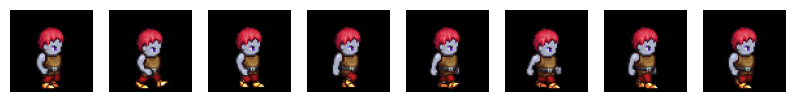

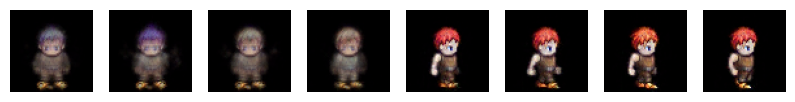

Reconstruction loss: 58.197078704833984


In [17]:
### TESTING RECONSTRUCTION ###
lldm = lldm.to('cpu')
lldm.eval()
#x = train_data[0].to('cuda').unsqueeze(0)


# z = lldm.encoder(x).embedding[0]
# _, z, _ = lldm.ddim_sampler.sample(shape = (1 , 3, 2, 2), x_last = z.reshape(1,3,2,2), cond = None)


# z = z.reshape(8,  12)
# x_rec = lldm.decoder(z).reconstruction

x = train_dataset[67]
x_rec = lldm(x, vi_index = 4).recon_x

x = x.data.unsqueeze(0)
x = x.to(x_rec.device)
plot_sequence(x.data)
plot_sequence(x_rec)

recon_loss = (
                0.5 * (
                    F.mse_loss(
                        x_rec.reshape(x.shape[0]*lldm.n_obs, -1),
                        x.reshape(x.shape[0]*lldm.n_obs, -1),
                        reduction="none"
                    )).sum(dim=-1).reshape(x.shape[0], -1)
            ).mean(dim=-1).item()

print('Reconstruction loss:', recon_loss)


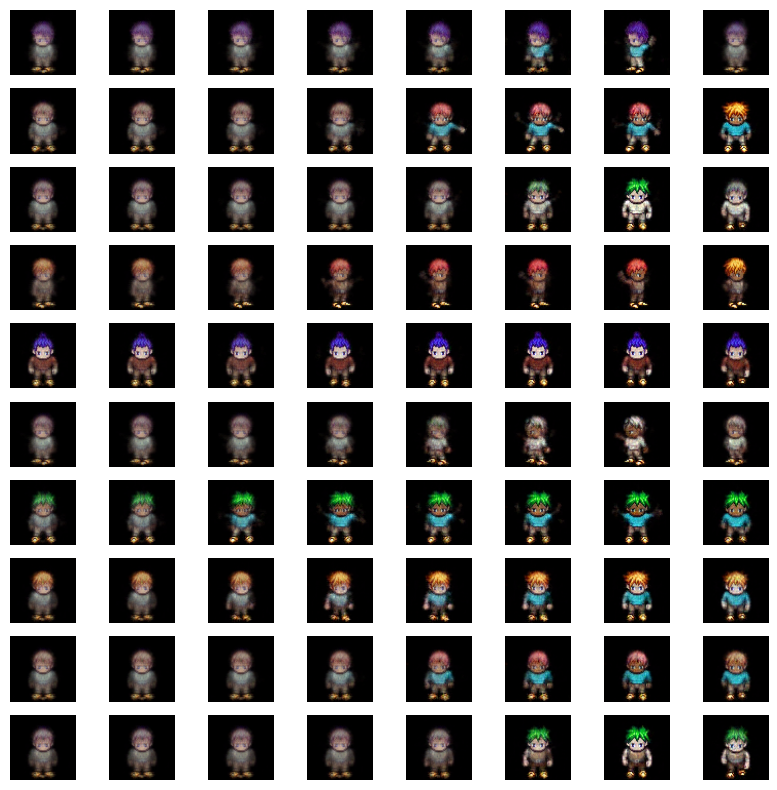

In [56]:
### TESTING GENERATION ###

lldm = lldm.to('cuda')
lldm.device = 'cuda'

lldm = lldm.eval()
recon_x = lldm.generate(10, temperature = 0.01)

plot_sequence(recon_x)



encoding done
tsne/pca done


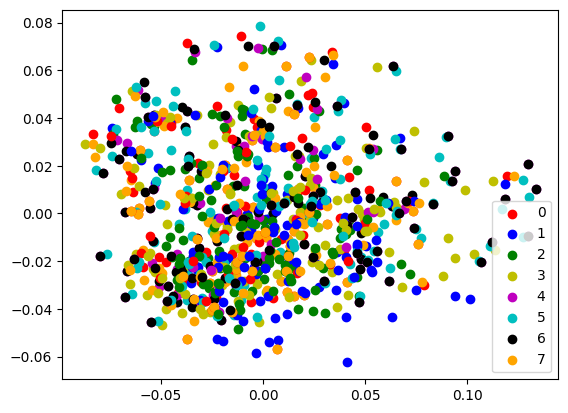

In [36]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

lldm = lldm.to('cpu')
#tsne = TSNE(n_components=2, random_state=0)
tsne = PCA(n_components=2)
z = lldm.encoder(train_data).embedding[:1000, :]
print('encoding done')
z = z.detach().cpu().numpy()
z = tsne.fit_transform(z)
print('tsne/pca done')


for i in range(1000):
    if i % 8 == 0:
        plt.scatter(z[i, 0], z[i, 1], c='r')
    elif i % 8 == 1:
        plt.scatter(z[i, 0], z[i, 1], c='b')
    elif i % 8 == 2:
        plt.scatter(z[i, 0], z[i, 1], c='g')
    elif i % 8 == 3:
        plt.scatter(z[i, 0], z[i, 1], c='y')
    elif i % 8 == 4:
        plt.scatter(z[i, 0], z[i, 1], c='m')
    elif i % 8 == 5:
        plt.scatter(z[i, 0], z[i, 1], c='c')
    elif i % 8 == 6:
        plt.scatter(z[i, 0], z[i, 1], c='k')
    else:
        plt.scatter(z[i, 0], z[i, 1], c='orange')

plt.legend(['0', '1', '2', '3', '4', '5', '6', '7'])  
plt.show()

## TO DO

#ergonomiser le Riemaniann sampling
- inspecter LVIAF
- train !

Possible pain points : le diffusion backward très bof (at least dans les intemédiaires). Après c'est du sampling... wait and see

30/05
Le problème du vanishing G a été résolu en passant à une dim latente de 12.
Il faut améliorer le diffusion model !
Eventuellemnt passer à du 16, puis 1, 4, 4 pour avoir des étages ce qui  n'est pas le cas now. Checker si on a pas de vansihing G.


04/06 Prêt à train (je crois ?) Il faudrait probablement tester les priors (à voir cmt)